In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from glob import glob
import os
from praatio import tgio
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
import sys
from datetime import datetime, timedelta
from tqdm import tqdm_notebook as tqdm
import copy
import pandas as pd
import pickle
from sklearn.externals.joblib import Parallel, delayed
import wave

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import avgn.segment_song.preprocessing as pp
import avgn.spectrogramming.spectrogramming as sg
import avgn.segment_song.wav_to_syllables as w2s

In [9]:
def norm_zero_one(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def read_grid(grid):
    tg = tgio.openTextgrid(grid)
    MotifTier = tg.tierDict['Motifs']
    return np.array(MotifTier.entryList).T

dt = h5py.special_dtype(vlen=str)
def save_dataset(location, all_bird_syll, starting_times,lengths,wav_file,syll_start_rel_to_wav,symbols, bird_name):
    with h5py.File(location, 'w') as f:
        f.attrs['bird_name'] = bird_name
        dset_spec = f.create_dataset("spectrograms", np.shape(all_bird_syll),dtype='uint8', data = all_bird_syll)        
        dset_start = f.create_dataset("start", data = np.array(starting_times).astype('S'))
        dset_wav_file = f.create_dataset("wav_file", data = np.array(wav_file).astype('S'))
        dset_syll_start_rel_to_wav = f.create_dataset("syll_start_rel_wav", 
                              np.shape(syll_start_rel_to_wav), dtype='float32', data = syll_start_rel_to_wav)
        dset_symbols = f.create_dataset("symbols", data = np.array(symbols).astype('S'))
        dset_lengths = f.create_dataset("lengths", np.shape(lengths), dtype='float32', data = lengths)

In [10]:
syll_size = 128
hparams = {
    'species':'CAVI',
    # filtering
    'highcut':20000,
    'lowcut':500,
    
    # spectrograms
    'mel_filter': True, # should a mel filter be used?
    'num_mels':syll_size, # how many channels to use in the mel-spectrogram
    'num_freq':512, # how many channels to use in a spectrogram 
    'num_freq_final': syll_size, # how many channels to use in the resized spectrogram
    'sample_rate':44100, # what rate are your WAVs sampled at?
    'preemphasis':0.97, 
    'min_silence_for_spec': 0.5, #minimum length of silence for a spectrogram to be considered a good spectrogram
    'frame_shift_ms':2, # step size for fft
    'frame_length_ms':10, # frame length for fft
    'min_level_db':-80, # minimum threshold db for computing spe 
    'spec_thresh_min': -20, # (db)
    'spec_thresh_delta': 5, # (db) what 
    'ref_level_db':70, # reference db for computing spec
    'sample_rate':44100, # sample rate of your data
    'fmin': 1200, # low frequency cutoff for mel filter
    'fmax': 10000, # high frequency cutoff for mel filter
    
    # Vocal Envelope
    'smoothing' : 'gaussian', # 'none', 
    'envelope_signal' : "spectrogram", # spectrogram or waveform, what to get the vocal envelope from
    'gauss_sigma_s': .001,
    'FOI_min': 4, # minimum frequency of interest for vocal envelope (in terms of mel)
    'FOI_max': 24, # maximum frequency of interest for vocal envelope (in terms of mel)
    
    # Silence Thresholding
    'silence_threshold' : 0, # normalized threshold for silence
    'min_len' : 5., # minimum length for a vocalization (fft frames)
    'power_thresh': .3, # Threshold for which a syllable is considered to be quiet weak and is probably noise

    # Syllabification
    'min_syll_len_s' : 0.25, # minimum length for a syllable
    'segmentation_rate': 0.0,#0.125, # rate at which to dynamically raise the segmentation threshold (ensure short syllables)
    'threshold_max': 0.25,
    'min_num_sylls': 20, # min number of syllables to be considered a bout
    'slow_threshold':0.0,#0.02, # second slower threshold
    'max_size_syll': syll_size, # the size of the syllable
    'resize_samp_fr': int(syll_size*1.5), # (frames/s) the framerate of the syllable (in compressed spectrogram time components)
    
    # Sencond pass syllabification
    'second_pass_threshold_repeats':50, # the number of times to repeat the second pass threshold
    'ebr_min': 0.25, # expected syllabic rate (/s) low 
    'ebr_max':  1.25, # expected syllabic rate (/s) high 
    'max_thresh':  0.02, # maximum pct of syllabic envelope to threshold at in second pass
    'thresh_delta':  0.005, # delta change in threshold to match second pass syllabification
    'slow_threshold': 0.005, # starting threshold for second pass syllabification
    
    'pad_length' : syll_size, # length to pad spectrograms to 
    
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':60,
    'power':1.5,

    # Thresholding out noise
    'mel_noise_filt' : 0.15, # thresholds out low power noise in the spectrum - higher numbers will diminish inversion quality
}
globals().update(hparams)
now_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # this is used to identify this training instance
# save the dictionary so that we can reload it for recovering waveforms
dict_save = '../../../data/parameter_dictionaries/'+now_string+'_dict.pickle'
with open(dict_save, 'wb') as f:
    pickle.dump(hparams, f, protocol=pickle.HIGHEST_PROTOCOL)
print(dict_save)

../../../data/parameter_dictionaries/2018-10-17_13-40-37_dict.pickle


In [11]:
### Mel Compression
_mel_basis = sg._build_mel_basis(hparams) # build a basis function if you are using a mel spectrogram

In [28]:
# point toward your downloaded dataset
bird_species = glob('../../../data/bird-db/CAVI*')
hdf5_save_loc = '/mnt/cube/tsainbur/Projects/github_repos/animalvocalizationgenerativenet/data/' 

In [29]:
key_list = (
            'all_bird_wav_file', # Wav file (bout_raw) that the syllable came from
            'all_bird_syll', # spectrogram of syllable
            'all_bird_syll_start', # time that this syllable occured
            'all_bird_t_rel_to_file', # time relative to bout file that this 
            'all_bird_syll_lengths', # length of the syllable
            'all_bird_symbol', # the symbolic representation of the syllable
           ) 

In [30]:
dataset_sizes = {}

In [31]:
verbose = True
plot_syllables= True
max_syllable_length = 1.0
max_size = 32

### Parse textgrids

In [32]:
song_df = pd.DataFrame(columns=['bird', 'species', 'WavTime', 'WavLoc', 'WaveFileName','Position','Length', 'NumNote', 'NotePositions', 'NoteLengths', 'NoteLabels'])
for species_folder in bird_species:
    species = species_folder.split('/')[-1]
    print(species)
    individuals = glob(species_folder+'/*')
    dataset_sizes[species] = []
    for individual_folder in tqdm(individuals, leave=False):
        individual = individual_folder.split('/')[-1]
        textgrids = glob(individual_folder+'/TextGrids/*.TextGrid')
        for textgrid_loc in tqdm(textgrids, leave=False):
            wav_time = datetime.strptime(textgrid_loc.split('/')[-1][:-9], "%Y-%m-%d_%H-%M-%S-%f")
            # load the textgrid
            try: 
                tg = tgio.openTextgrid(textgrid_loc)
            except:
                print('TextGrid did not load')
                continue
            # extract song from tiers
            all_tiers = [tg.tierDict[tier].entryList for tier in tg.tierDict]
            main_tier = all_tiers[0]
            # create entry for symbolid df
            if len(np.array(main_tier).T) == 0:
                continue
            start_list, stop_list, label_list = np.array(main_tier).T
            # load the wav
            wav_loc = '/'.join(textgrid_loc.split('/')[:-2] + ['wavs'] + [textgrid_loc.split('/')[-1][:-9]+'.wav'])
            if not os.path.exists(wav_loc): continue
            with wave.open(wav_loc, "rb") as wave_file:
                rate = wave_file.getframerate()
            # create row
            song_df.loc[len(song_df)] = [individual, species, wav_time, wav_loc, wav_loc.split('/')[-1],None, None, len(main_tier),
                             list((np.array([i.start for i in main_tier])*rate).astype('int')),
                             list((np.array([i.end - i.start for i in main_tier])*rate).astype('int')),
                             [i.label for i in main_tier],
                            ]

CAVI


In [33]:
song_df[:5]

,bird,species,WavTime,WavLoc,WaveFileName,Position,Length,NumNote,NotePositions,NoteLengths,NoteLabels
0,GAY,CAVI,2014-06-18 06:57:00,../../../data/bird-db/CAVI/GAY/wavs/2014-06-18...,2014-06-18_06-57-00-000000.wav,None,None,19,"[62012, 169081, 231228, 312339, 429609, 502474...","[11604, 13437, 14811, 31913, 14200, 14506, 323...","[je, ah, cd, cb, ds, cd, cb, ds, cd, cb, ff, j..."
1,GAY,CAVI,2014-06-16 08:19:00,../../../data/bird-db/CAVI/GAY/wavs/2014-06-16...,2014-06-16_08-19-00-000000.wav,None,None,786,"[82685, 192242, 266227, 360682, 452848, 530265...","[13066, 14932, 13575, 16629, 13284, 14964, 137...","[fg, ck, ea, fc, fg, ck, ea, ck, ea, fc, fg, c..."
2,GAY,CAVI,2014-06-16 07:32:00,../../../data/bird-db/CAVI/GAY/wavs/2014-06-16...,2014-06-16_07-32-00-000000.wav,None,None,151,"[89345, 202216, 261157, 323333, 392962, 459567...","[14506, 12368, 15727, 13895, 17101, 12979, 145...","[ck, fg, ck, ea, fc, fg, ck, ea, fc, fg, ck, e..."
3,GAY,CAVI,2014-06-05 08:18:00,../../../data/bird-db/CAVI/GAY/wavs/2014-06-05...,2014-06-05_08-18-00-000000.wav,None,None,112,"[12547606, 12735785, 12809232, 12876600, 12969...","[12673, 14047, 14506, 30386, 13742, 15422, 322...","[hi, ds, cd, cb, ds, cd, cb, ds, cd, ff, jo, i..."
4,Sailor Flat,CAVI,2014-06-23 10:56:00,../../../data/bird-db/CAVI/Sailor Flat/wavs/20...,2014-06-23_10-56-00-000000.wav,None,None,5,"[11014067, 11347489, 11531517, 11741990, 13705...","[12673, 10077, 13589, 12215, 13284]","[cg, cr, cg, cr, cg]"


In [34]:
len(song_df)

415

### Get syllables from wavs

In [35]:
key_list = (
            'all_bird_wav_file', # Wav file (bout_raw) that the syllable came from
            'all_bird_syll', # spectrogram of syllable
            'all_bird_syll_start', # time that this syllable occured
            'all_bird_t_rel_to_file', # time relative to bout file that this 
            'all_bird_syll_lengths', # length of the syllable
            'all_bird_symbol', # the symbolic representation of the syllable
           ) 

In [36]:
parallel = True
verbosity=0
n_jobs=20
save=True

In [37]:
hparams['pct_fail'] = .8 # minimum percentage of spectral slice without power to be considered good
hparams['power_thresh'] = .25

YBuA 2638


len dataset:  2638


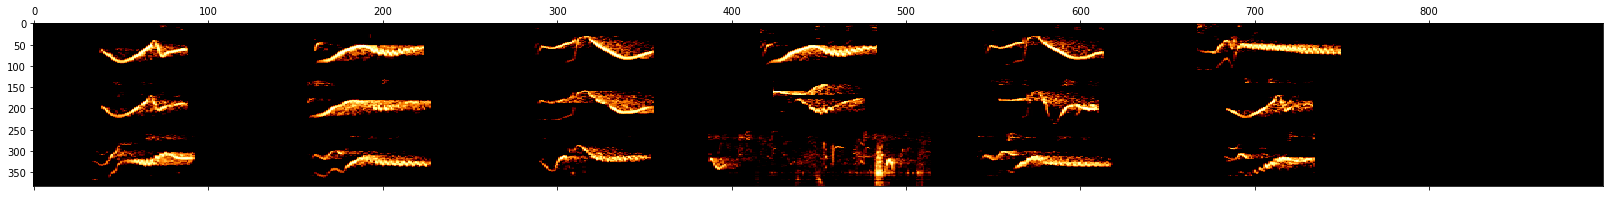

YAW 3372


WAV file did not load: ../../../data/bird-db/CAVI/YAW/wavs/2014-05-28_10-41-00-000000.wav
len dataset:  3149


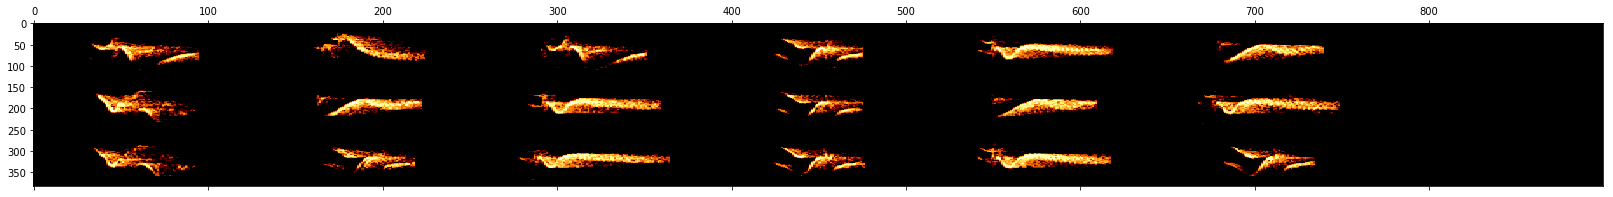

WABk 7513


WAV file did not load: ../../../data/bird-db/CAVI/WABk/wavs/2014-05-29_10-04-00-000000.wav
len dataset:  6430


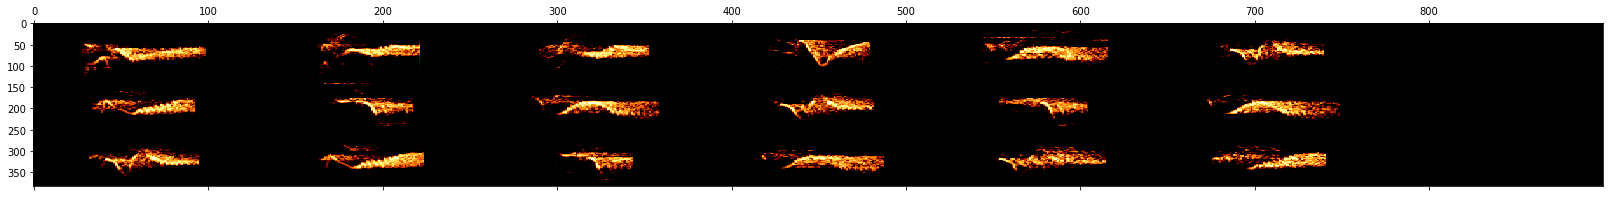

Unbanded East 2324


len dataset:  2323


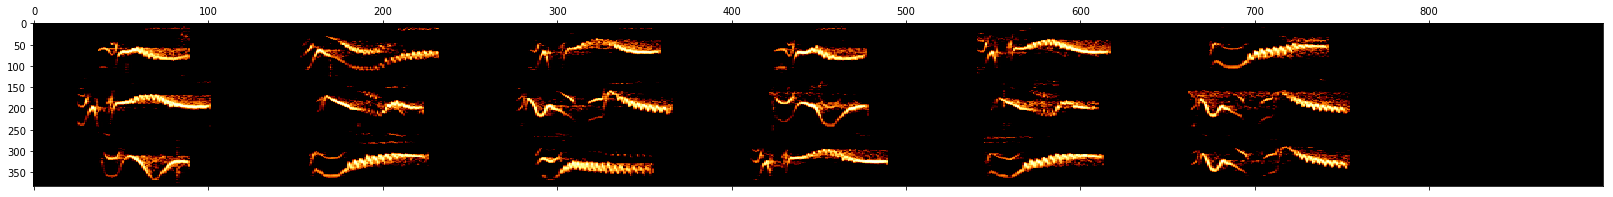

RYA 3582


WAV file did not load: ../../../data/bird-db/CAVI/RYA/wavs/2014-05-23_15-24-00-000000.wav
len dataset:  3565


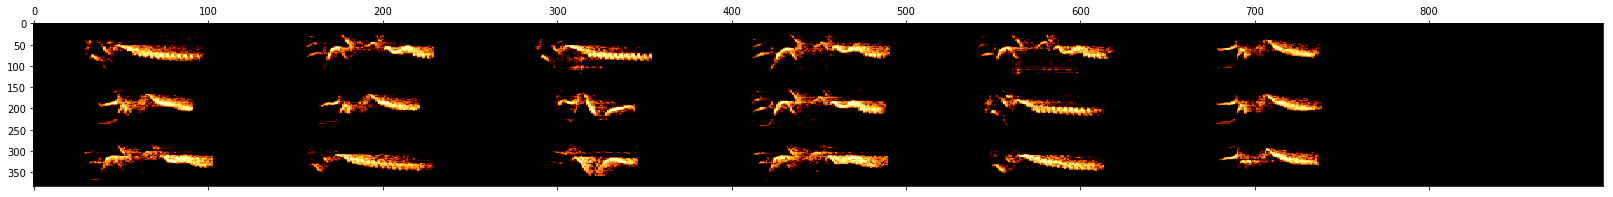

ORA 2805


len dataset:  2805


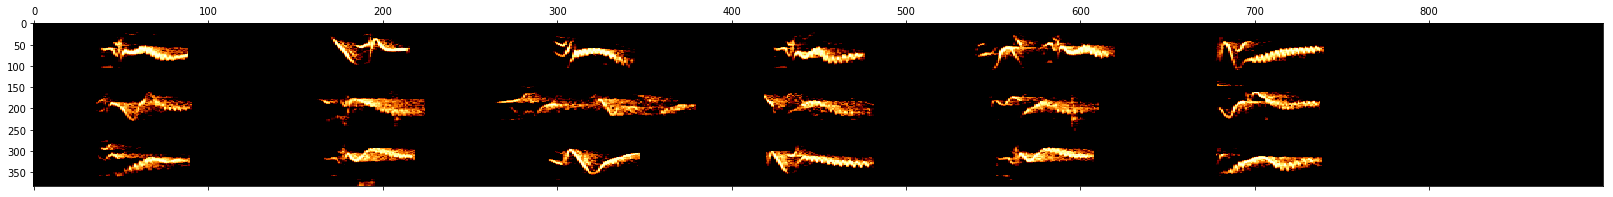

Meadow 1515


len dataset:  1515


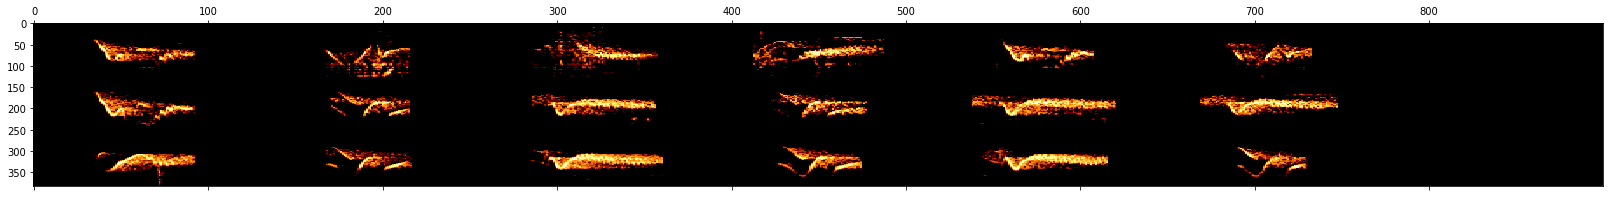

Gate CAVI 1136


len dataset:  1136


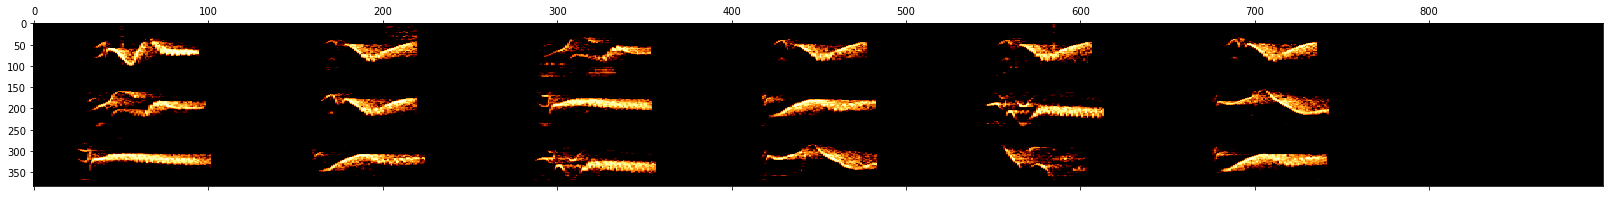

GRA 3045


len dataset:  3045


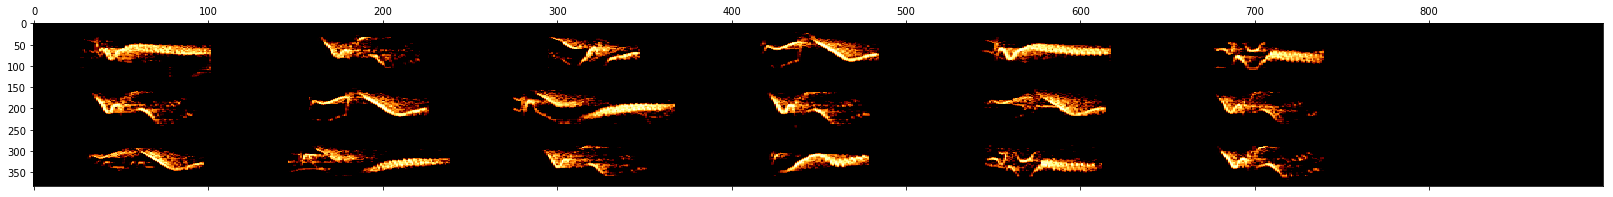

GAY 1068


len dataset:  1068


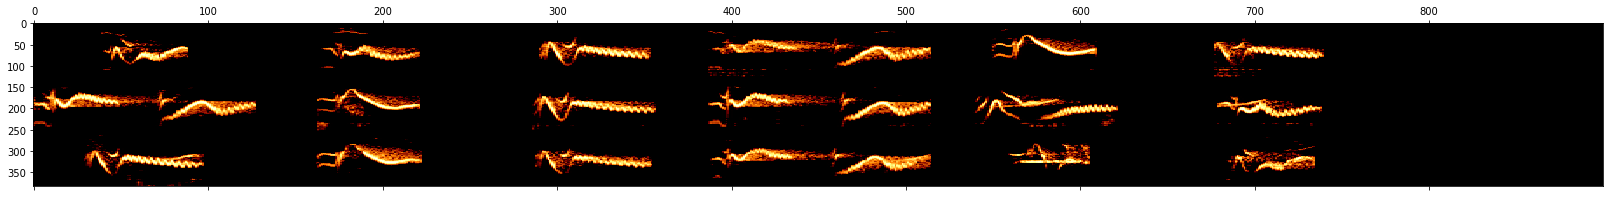

CAVIFTANN-Spingr10 1009


len dataset:  1005


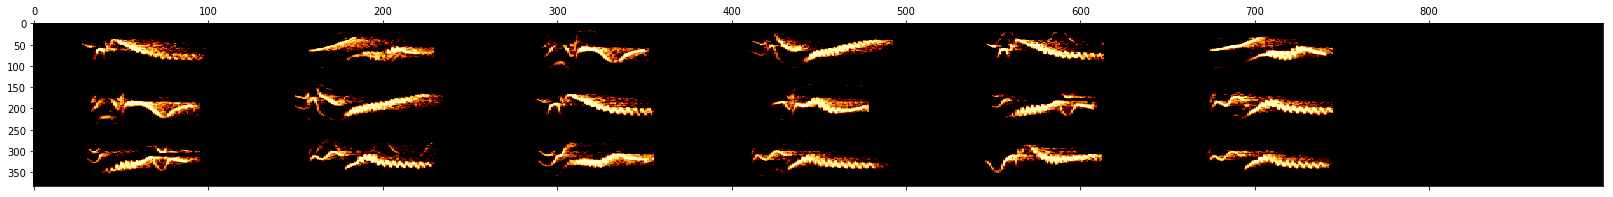

BuRA 5527


len dataset:  5527


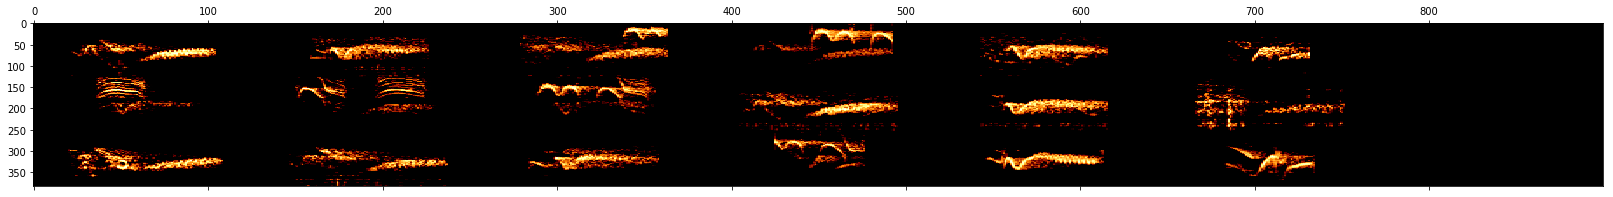

AYO 1543


WAV file did not load: ../../../data/bird-db/CAVI/AYO/wavs/2014-05-06_12-18-00-000000.wav
len dataset:  1464


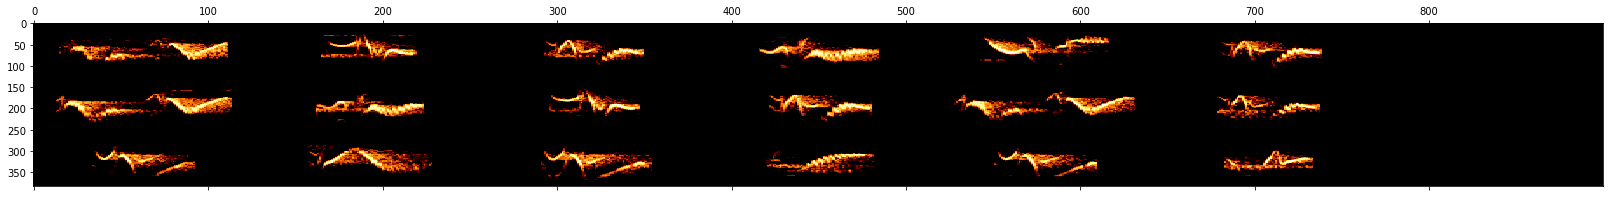

AOBu 7704


WAV file did not load: ../../../data/bird-db/CAVI/AOBu/wavs/2013-06-26_14-48-00-000000.wav
len dataset:  7638


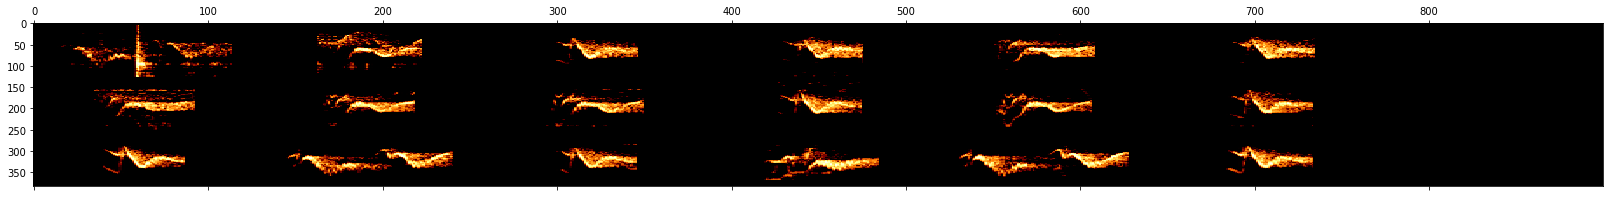

AGO 4595


WAV file did not load: ../../../data/bird-db/CAVI/AGO/wavs/2014-05-28_07-21-00-000000.wav
WAV file did not load: ../../../data/bird-db/CAVI/AGO/wavs/2014-05-23_09-25-00-000000.wav
WAV file did not load: ../../../data/bird-db/CAVI/AGO/wavs/2013-06-06_15-36-00-000000.wav
WAV file did not load: ../../../data/bird-db/CAVI/AGO/wavs/2014-05-14_15-52-00-000000.wav
WAV file did not load: ../../../data/bird-db/CAVI/AGO/wavs/2013-06-06_15-53-00-000000.wav
len dataset:  3869


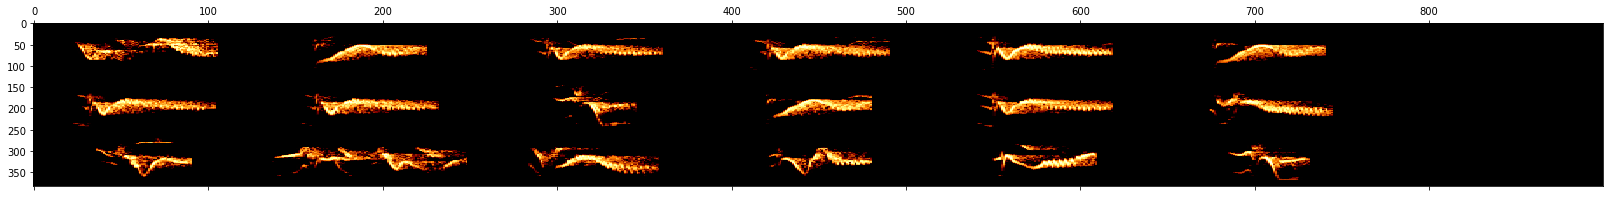

AGBk 9395


WAV file did not load: ../../../data/bird-db/CAVI/AGBk/wavs/2013-06-27_12-07-00-000000.wav
Mismatched time in textgrid/wav ../../../data/bird-db/CAVI/AGBk/wavs/2013-06-27_06-08-00-000000.wav
WAV file did not load: ../../../data/bird-db/CAVI/AGBk/wavs/2014-05-24_11-18-00-000000.wav
WAV file did not load: ../../../data/bird-db/CAVI/AGBk/wavs/2014-05-12_07-11-00-000000.wav
WAV file did not load: ../../../data/bird-db/CAVI/AGBk/wavs/2013-06-26_05-59-00-000000.wav
len dataset:  8185


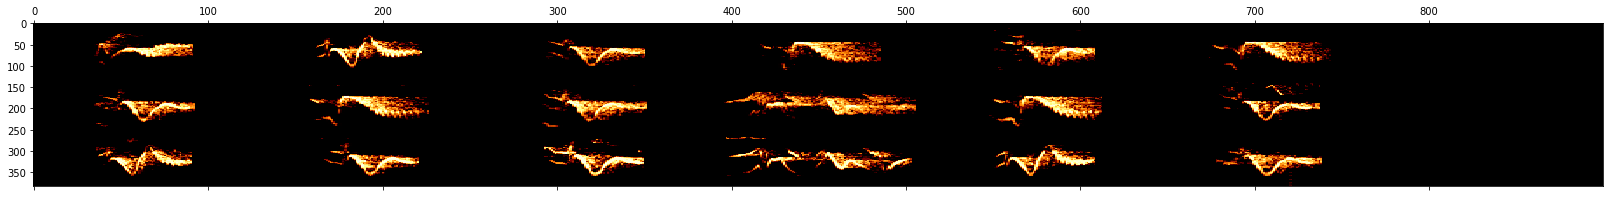

In [38]:
for indv in tqdm(np.unique(song_df.bird)[::-1]):
    num_notes = np.sum(song_df[song_df.bird ==indv].NumNote)
    if num_notes < 1000: continue
    print(indv, num_notes)
    if parallel:
        with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
            bird_data_packed  = parallel(
                    delayed(w2s.getSyllsFromWav)(row, _mel_basis, row.WavTime, hparams) 
                for idx, row in tqdm(song_df[song_df.bird ==indv].iterrows(),
                                     total=np.sum(song_df.bird ==indv), leave=False))
    else:
        bird_data_packed = [w2s.getSyllsFromWav(row, _mel_basis, row.WavTime, hparams) 
                for idx, row in tqdm(song_df[song_df.bird ==indv].iterrows(),
                                     total=np.sum(song_df.bird ==indv), leave=False)]
    bird_data_packed = [i for i in bird_data_packed if i is not None]
    bird_data_packed = [item for sublist in bird_data_packed for item in sublist]
    bird_data_packed = [i for i in bird_data_packed if i is not None]
    #initialize lists of bird information
    bird_data = {key : [] for key in key_list}
    for dtype, darray in zip(key_list, list(zip(*bird_data_packed))):
        for element in darray:bird_data[dtype].append(element) # flatten and clear darray -> bird_data[dtype]
        bird_data[dtype] = np.array(bird_data[dtype])
    # reformat bird syllables
    print('len dataset: ', len(bird_data['all_bird_syll_lengths']))
    save_loc =hdf5_save_loc + species + '_wavs/' + indv.replace(" ", "_") + '_' + str(syll_size)+'.hdf5'
    if save:
        save_dataset(save_loc, 
             bird_data['all_bird_syll'], 
             bird_data['all_bird_syll_start'].astype('object'),
             bird_data['all_bird_syll_lengths'], 
             bird_data['all_bird_wav_file'].astype('object'),
             bird_data['all_bird_t_rel_to_file'],
             bird_data['all_bird_symbol'],
             indv
            )
    if plot_syllables and len(bird_data['all_bird_syll']) > 0:  w2s.plt_all_syllables( bird_data['all_bird_syll'], syll_size, max_rows=3, max_sylls=100, width=900, zoom = 1, cmap=plt.cm.afmhot)
